# Fine-Tuning a LLM for Reasoning

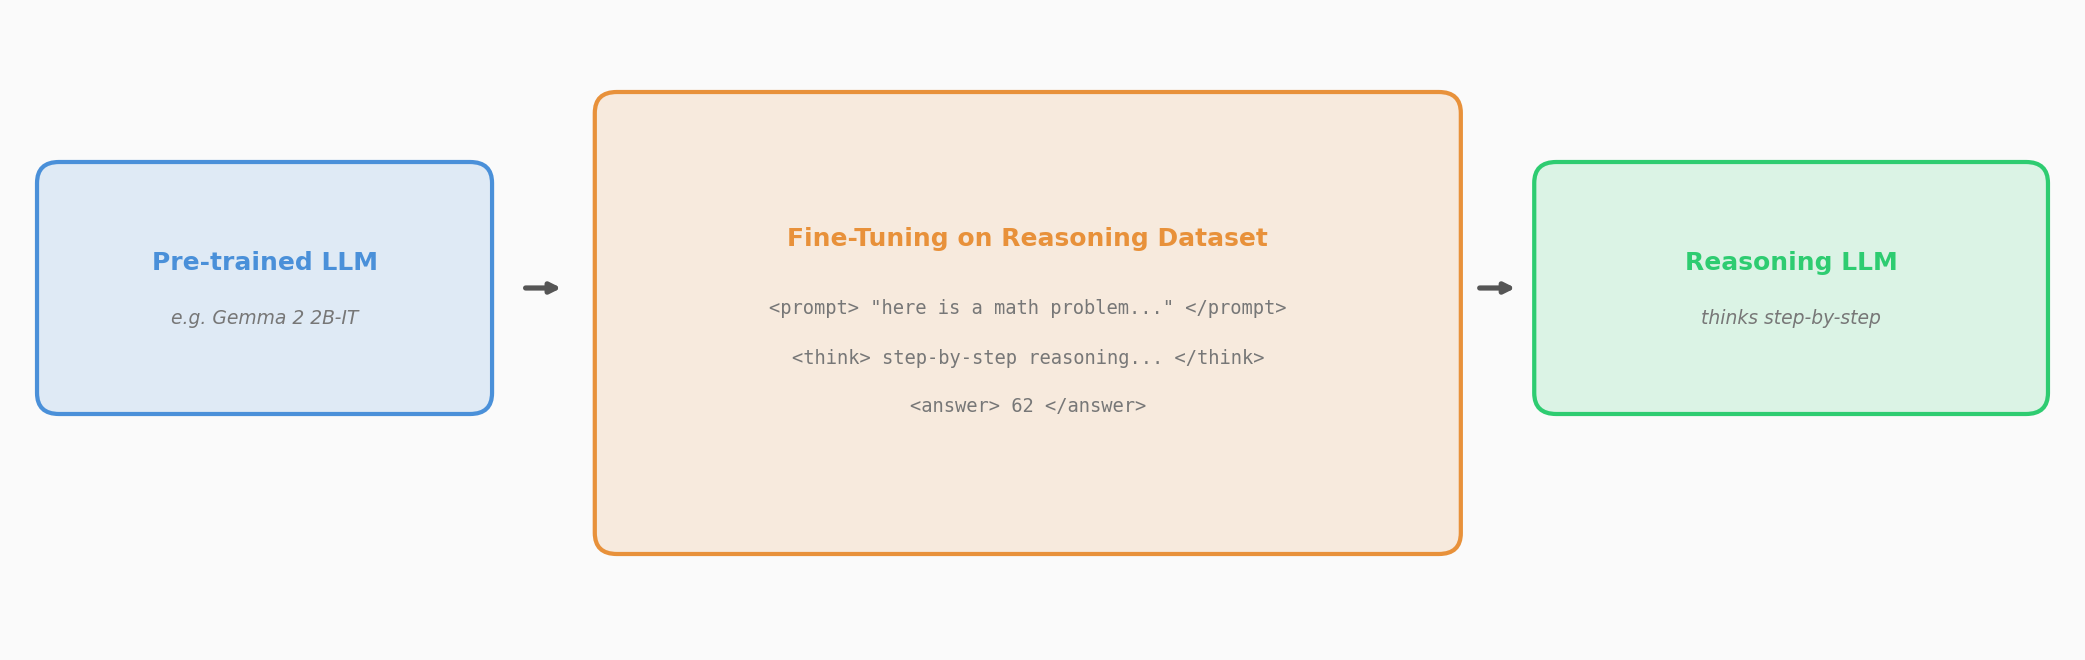

In [1]:
from IPython.display import Image, display
display(Image(filename="fine_tuning_reasoning_overview.png"))

### Here's a few initial command useful when setting up things on Google Colab

In [ ]:
# # Only when running on Google Colab
# !pip install datasets
# import os
# os.environ["WANDB_DISABLED"] = "true"
#!git clone https://github.com/alan-turing-institute/open-llms-101.git
#!mv open-llms-101/R1-Distill-SFT-sample ./

### Select a model and a dataset of reasoning examples

In [ ]:
import torch
from threading import Thread
from datasets import load_dataset, load_from_disk
from transformers import AutoTokenizer, AutoModelForCausalLM, TextIteratorStreamer

# Load model and tokenizer
model_name = "PleIAs/Pleias-1.2b-Preview" # or "google/gemma-2-2b-it" if you already have an huggingface account and have access to the model

trial = True
dataset_percentage = "sample" if trial else 1 # Change to 100 to use the whole dataset

if trial:
    dataset = load_from_disk("R1-Distill-SFT-sample")
else:
    dataset = load_dataset("ServiceNow-AI/R1-Distill-SFT", "v1", split="train")
    num_examples = int(len(dataset) * dataset_percentage / 100)

    # Select the first `num_examples` from the dataset
    dataset = dataset.select(range(num_examples))

print (f"Dataset size: {len(dataset)}")

### Setup of the model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype=torch.float16)

# Check if pad_token is set; if not, set it
if tokenizer.pad_token is None:
    print ("Pad token not set; setting to '[PAD]'")
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    # Resize model embeddings to match the tokenizer
    model.resize_token_embeddings(len(tokenizer))

### Define a function for "chat" abilities

In [ ]:
def chat(model, prompt, length):
    # Prepare the input prompt
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Set up the streamer
    streamer = TextIteratorStreamer(tokenizer, skip_prompt=False, skip_special_tokens=True)

    # Generate tokens in a separate thread to allow streaming
    generation_kwargs = dict(
        inputs=inputs.input_ids,
        attention_mask=inputs['attention_mask'],
        max_new_tokens=length,
        temperature=0.7,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        pad_token_id=tokenizer.eos_token_id,
        streamer=streamer
    )

    # Start generation in a new thread
    thread = Thread(target=model.generate, kwargs=generation_kwargs)
    thread.start()

    # Stream output token by token
    for new_text in streamer:
        print(new_text, end="", flush=True)

    # Wait for the thread to finish
    thread.join()

### Testing generating content abilities

In [ ]:
# Start a chat session
prompt = "What is The Alan Turing Institute?"
chat(model, prompt, length=200)

### Prepare the reasoning dataset for fine-tuning

In [ ]:
import os
from peft import LoraConfig, get_peft_model, TaskType
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling

# Function to format examples
def format_example(example):
    messages = example["reannotated_messages"]    
    # Extract user input (prompt)
    user_input = next(msg["content"] for msg in messages if msg["role"] == "user")
    
    # Extract assistant response (reasoning + final answer)
    assistant_response = " ".join(msg["content"] for msg in messages if msg["role"] == "assistant")
    assistant_response = assistant_response.replace("</think>", "</think><answer>") + "</answer>"
    return {"text": "<prompt>"+ user_input + "</prompt>" + assistant_response}

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

In [ ]:
dataset[0]

### Setup fine-tuning and start the training

In [ ]:
filename = f"trained_models/{dataset_percentage}_fine_tuned_{model_name.split('/')[-1]}"

if os.path.exists(filename):
    print(f"File {filename} already exists, skipping fine-tuning")

else:
    # Process examples in parallel
    dataset = dataset.map(format_example, num_proc=4)

    # Tokenize efficiently
    tokenized_datasets = dataset.map(tokenize_function, batched=False, num_proc=4)

    # Define LoRA configuration
    lora_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM,
        r=8,  # Rank
        lora_alpha=16,
        lora_dropout=0.1
    )

    # Apply LoRA to the model
    peft_model = get_peft_model(model, lora_config)

    # Define data collator
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False,
    )

    # Define training arguments
    training_args = TrainingArguments(
        output_dir="trained_models/results",
        per_device_train_batch_size=4,
        num_train_epochs=1,
        logging_dir="trained_models/logs",
        logging_steps=10
    )

    # Define the Trainer
    trainer = Trainer(
        model=peft_model,
        args=training_args,
        train_dataset=tokenized_datasets,
        data_collator=data_collator
    )

    # Fine-tune the model
    trainer.train()
    
    # Save the model and tokenizer
    peft_model.save_pretrained(filename)
    tokenizer.save_pretrained(filename)

### Test reasoning capabilities

In [ ]:
from peft import PeftModel

# Load PEFT adapter
reload_peft_model = PeftModel.from_pretrained(model, filename)

# Prepare the input prompt
prompt = "<prompt>Alice, Bob, and Charlie are in a room. Alice always tells the truth, Bob always lies, and Charlie sometimes lies and sometimes tells the truth. You ask each of them, ‘Is Charlie a truth-teller?’ Alice says, ‘No.’ Bob says, ‘Yes.’ Charlie says, ‘I sometimes lie.’ Who is telling the truth?</prompt>"

# Generate text
chat(reload_peft_model, prompt, length=500)

### Load the fully trained model from Hugging Face

The model above was trained on a small sample. Let's now load a version trained on 1% of the dataset to see how much the reasoning improves.

In [ ]:
# Load the base model that the adapter was trained on
trained_model_name = "google/gemma-2-2b-it"
trained_base_model = AutoModelForCausalLM.from_pretrained(trained_model_name, device_map="auto", torch_dtype=torch.float16)

# Load the matching tokenizer for the new base model
tokenizer = AutoTokenizer.from_pretrained(trained_model_name)

# Load the fully trained adapter from Hugging Face
trained_adapter = "fedenanni/gemma-2-2b-it-reasoning"
trained_peft_model = PeftModel.from_pretrained(trained_base_model, trained_adapter)

In [ ]:
# Test with the same prompt
chat(trained_peft_model, prompt, length=500)